# Complete Attack to Recover the 6th Byte of the Key

This notebook shows a complete attack to a single byte, specifically the 6th byte (index 5).

**The train-configuration is composed by 2 devices (D1, D2) and all possible keys (all device-key permutations)**, exept K0, which is attacked.\
**The attack-configuration is D3-K0**.\
The scenario is **Multiple Device Model (MDM)**, where multiple devices are used in training and a different device is attacked.

The following results and metrics are shown:
* **Train Loss & Validation Loss**
* **Train Accuracy & Validation Accuracy**
* **Attack Loss & Attack Accuracy**
* **Confusion Matrix**
* **Guessing Entropy**

In [1]:
# Basics
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Custom
import sys
sys.path.insert(0, '../src/utils')
import helpers
import results
import constants
from data_loader import DataLoader, SplitDataLoader
sys.path.insert(0, '../src/modeling')
from models import mlp

# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

In [2]:
# visualization.py module cannot be imported because it uses non-GUI matplotlib backend.
# Non-GUI backends does NOT allow to show figures, so new functions are needed for this notebook.

def plot_history(history, metric, output_path):
    
    """
    Plots the training history (train_loss vs val_loss, train_acc vs val_acc).
    
    Parameters:
        - history (dict):
            Train history.
        - metric (str):
            Metric to plot.
        - output_path (str):
            Absolute path to the .SVG file containing the plot.
    """
    
    f = plt.figure(figsize=(10,10))

    train_label = f'train_{metric}'
    val_label = f'val_{metric}'
    title = f'Train and Val {metric.title()}' # .title() upper-cases only the first letter
    
    plt.plot(history[metric], label=train_label)
    plt.plot(history[val_label], label=val_label)
    plt.title(title)
    plt.ylabel(metric.title())
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid()
    
    f.savefig(
        output_path, 
        bbox_inches='tight', 
        dpi=600
    )
    
    plt.show()
    
    plt.close(f)
    
    
def plot_conf_matrix(conf_matrix, output_path):
    
    cmap = plt.cm.Blues
    
    f = plt.figure(figsize=(10,8))
    
    plt.imshow(conf_matrix, cmap=cmap)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    
    plt.colorbar()
    
    f.savefig(
        output_path,
        bbox_inches='tight',
        dpi=600
    )
    
    plt.show()
    
    plt.close(f)
    
    
def plot_ge(ge, output_path):

    """
    Plots the provided GE vector.
    
    Parameters:
        - ge (np.array):
            GE vector to plot.
        - output_path (str):
            Absolute path to the PNG file containing the plot.
    """
    
    # Plot GE
    f, ax = plt.subplots(figsize=(15,8))
    
    ax.plot(ge, marker='o', color='b')
        
    ax.set_title(f'Train Devices: D1, D2  |  Test Device: D3')
    ax.set_xticks(range(len(ge)), labels=range(1, len(ge)+1)) 
    ax.set_xlabel('Number of traces')
    ax.set_ylabel('GE')
    ax.grid()

    f.savefig(
        output_path, 
        bbox_inches='tight', 
        dpi=600
    )
    
    plt.show()
    
    plt.close(f)


def plot_probs(prob_values, true_label, title, output_path):

    f = plt.figure(figsize=(15,8))

    for i in range(256):
        plt.plot([i, i], [0, prob_values[i]], color='b')
        plt.plot([i], [prob_values[i]], marker='o', color='b')

    plt.axvline(x=true_label, color='r', linestyle='--', label='True Label')

    plt.title(title)
    plt.xlabel('Labels')
    plt.ylabel('Prediction Probability')
    plt.legend(loc='upper right')
    plt.grid()

    plt.savefig(
        output_path,
        bbox_inches='tight', 
        dpi=600
    )

    plt.show()

    plt.close(f)

In [3]:
RES_ROOT = f'{constants.RESULTS_PATH}/DKTA/SBOX_OUT/byte5/2d' 
HP_PATH = RES_ROOT + '/hp.json'

SINGLE_ATTACK_FOLDER = f'{constants.RESULTS_PATH}/SingleAttack_Byte5'
MODEL_PATH = SINGLE_ATTACK_FOLDER + f'/model_b5.h5'

# Every plot has a .CSV file with data and a .svg file with the plot
LOSS_HIST_FILE = SINGLE_ATTACK_FOLDER + '/loss_hist.csv'
LOSS_HIST_PLOT = SINGLE_ATTACK_FOLDER + '/loss_hist.svg'

ACC_HIST_FILE = SINGLE_ATTACK_FOLDER + '/acc_hist.csv'
ACC_HIST_PLOT = SINGLE_ATTACK_FOLDER + '/acc_hist.svg'

CONF_MATRIX_FILE = SINGLE_ATTACK_FOLDER + '/conf_matrix.csv'
CONF_MATRIX_PLOT = SINGLE_ATTACK_FOLDER + '/conf_matrix.svg'

PROBS_MC_FILE = SINGLE_ATTACK_FOLDER + '/probs_mc.csv'
PROBS_MC_PLOT = SINGLE_ATTACK_FOLDER + '/probs_mc.svg'
PROBS_B_FILE = SINGLE_ATTACK_FOLDER + '/probs_b.csv'
PROBS_B_PLOT = SINGLE_ATTACK_FOLDER + '/probs_b.svg'
PROBS_W_FILE = SINGLE_ATTACK_FOLDER + '/probs_w.csv'
PROBS_W_PLOT = SINGLE_ATTACK_FOLDER + '/probs_w.svg'

GE_FILE = SINGLE_ATTACK_FOLDER + '/ge.csv'
GE_PLOT = SINGLE_ATTACK_FOLDER + '/ge.svg'

TRAIN_DEVS = ['D1', 'D2']
TEST_FILES = [f'{constants.PC_TRACES_PATH}/D3-K0_500MHz + Resampled.trs'] # list is needed in DataLoader

## Training

In [4]:
# Get train data
train_files = [f'{constants.PC_TRACES_PATH}/{d}-{k}_500MHz + Resampled.trs' 
               for k in list(constants.KEYS)[1:]
               for d in TRAIN_DEVS]

train_dl = SplitDataLoader(
    train_files, 
    tot_traces=50000,
    train_size=0.9,
    target='SBOX_OUT',
    byte_idx=5
)
train_data, val_data = train_dl.load()
x_train, y_train, _, _ = train_data 
x_val, y_val, _, _ = val_data

# Scale data to 0-mean and 1-variance
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)


# Get hyperparameters
with open(HP_PATH, 'r') as jfile:
    hp = json.load(jfile)


# Train and save the model
model = mlp(
    hp=hp, 
    input_len=x_train.shape[1], 
    n_classes=y_train.shape[1]
)
model.summary()

callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=15
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=7,
        min_lr=1e-7),
    ModelCheckpoint(
        MODEL_PATH,
        monitor='val_loss',
        save_best_only=True
    )
]

history = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=hp['batch_size'],
    callbacks=callbacks,
    verbose=0
).history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1183)              1400672   
                                                                 
 batch_normalization (BatchN  (None, 1183)             4732      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1183)              0         
                                                                 
 dense_1 (Dense)             (None, 500)               592000    
                                                                 
 batch_normalization_1 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 500)               0

The summary shows the **strucure of the model** and the **number of parameters per layer**.

### Training History

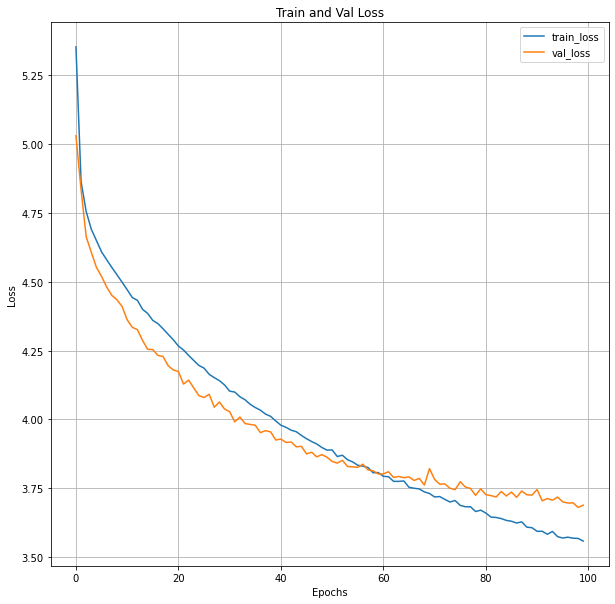

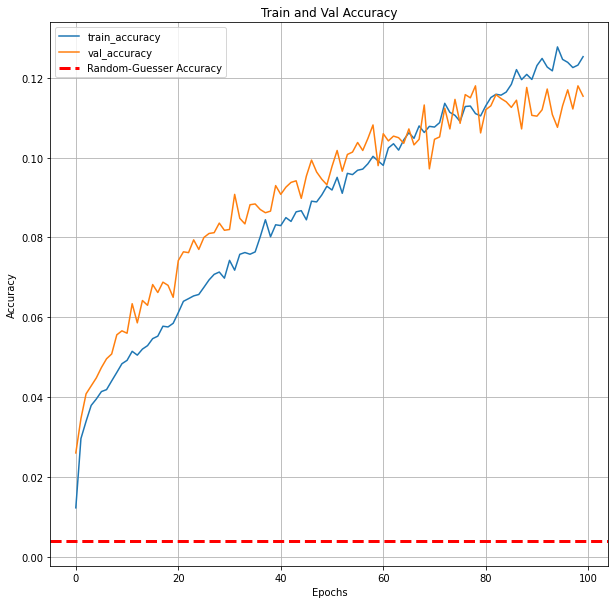

In [5]:
actual_epochs = len(history['loss']) # Early Stopping can make the actual 
                                     # number of epochs different from the original one
# Loss
loss_data = np.vstack(
    (
        np.arange(actual_epochs)+1, # X-axis values
        history['loss'], # Y-axis values for 'loss'
        history['val_loss'] # Y-axis values for 'val_loss'
    )
).T
helpers.save_csv(
    data=loss_data, 
    columns=['Epochs', 'Loss', 'Val_Loss'],
    output_path=LOSS_HIST_FILE
)
plot_history(history, 'loss', LOSS_HIST_PLOT)

# Accuracy
acc_data = np.vstack(
    (
        np.arange(actual_epochs)+1, # X-axis values
        history['accuracy'], # Y-axis values for 'loss'
        history['val_accuracy'] # Y-axis values for 'val_loss'
    )
).T
helpers.save_csv(
    data=acc_data, 
    columns=['Epochs', 'Acc', 'Val_Acc'],
    output_path=ACC_HIST_FILE
)
plot_history(history, 'accuracy', ACC_HIST_PLOT)

**Validation-metrics are better than train-metrics for a while**. 
However, at the end of the training process, the validation-metrics are slightly worse than the train-metrics.

This is a strange behavior, most probably caused by the following reasons:
* **Regularization**: it is applied during training, while it is removed during the validation step, leading to a penalized model during training and a potentially better one for validation (in this case Dropout is applied with a 40% chance);
* **Metrics computation**: train-metrics are computed *during* each epoch, while validation-metrics are measured *after* each epoch, resulting in a slight misalignment.

However, **validation-metrics do not diverge from train-metrics**, showing that **the model is not overfitting** the data.

The model shows also a very good Validation Accuracy for the problem: **the model outperforms a Random-Guesser**, whose accuracy is 1/256 ~ 0.0039.

## Attack

In [6]:
attack_dl = DataLoader(
    TEST_FILES, 
    tot_traces=50000,
    target='SBOX_OUT',
    byte_idx=5
)
x_attack, y_attack, pbs_attack, tkb_attack = attack_dl.load()

# Scale data to 0-mean and 1-variance
x_attack = scaler.transform(x_attack)

attack_model = load_model(MODEL_PATH)

### Attack Loss & Attack Accuracy

In [7]:
attack_loss, attack_acc = attack_model.evaluate(x_attack, y_attack, verbose=0)

print(f'Attack Loss:     {attack_loss:.2f}')
print(f'Attack Accuracy: {(attack_acc*100):.2f}%')

Attack Loss:     4.65
Attack Accuracy: 5.51%


The obtained results are not the best for a classical classification problem, but they are **enough for this specific scenario**.\
Indeed, **in Deep Learning based SCAs there is the additional step of "combining the single predictions", because all the input data share the true objective of the attack, the key**.

However, it is interesting to see the values of the metrics because both hyperparameter tuning and training callbacks are based on them, specifically on validation loss.

### Confusion Matrix

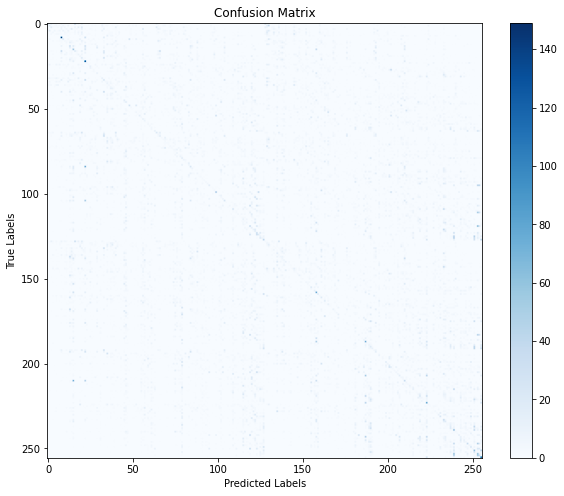

In [8]:
preds = attack_model.predict(x_attack)

# From one-hot-encoding to true labels in [0;255]
y_true = [el.tolist().index(1) for el in y_attack] 
y_pred = [el.tolist().index(max(el)) for el in preds]

cm_data = confusion_matrix(y_true, y_pred)

helpers.save_csv(
    data=cm_data, 
    columns=[f'Col_{i+1}' for i in range(cm_data.shape[1])],
    output_path=CONF_MATRIX_FILE
)

plot_conf_matrix(cm_data, CONF_MATRIX_PLOT)

The ideal confusion matrix has values only on the main diagonal (each predicted label matches the corresponding true label).\
In this case there are misclassifications, but **the main diagonal is still visible**, meaning that the model is not a random guesser.

The **misclassifications are consequence of the low attack accuracy** (~11%).\
However, **this result is good enough to allow the correct key-byte recovery**.

### Guessing Entropy

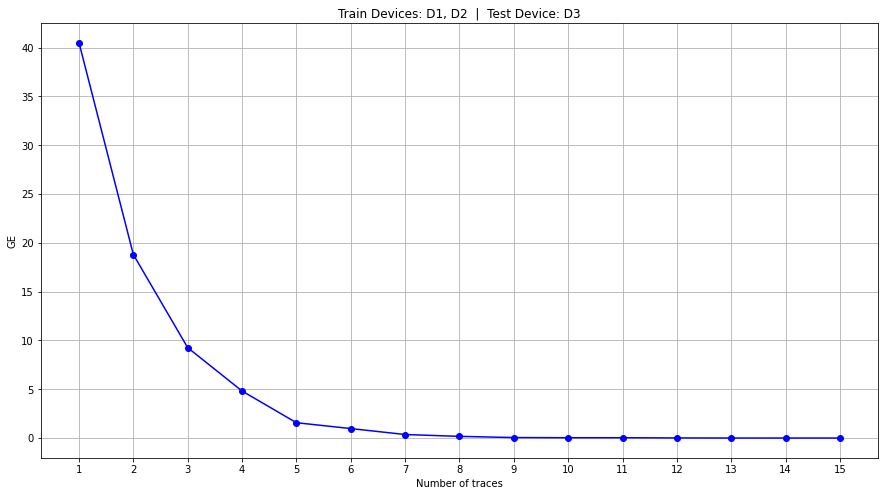

In [9]:
ge = results.ge(
    model=attack_model,
    x_test=x_attack,
    pltxt_bytes=pbs_attack, 
    true_key_byte=tkb_attack, 
    n_exp=100, 
    target='SBOX_OUT'
)

plottable_ge = ge[:15]

csv_ge_data = np.vstack(
    (
        np.arange(plottable_ge.shape[0])+1,
        plottable_ge
    )
).T

helpers.save_csv(
    data=csv_ge_data, 
    columns=['NTraces', 'GE'],
    output_path=GE_FILE
)

plot_ge(plottable_ge, GE_PLOT)

The overall performance is very good: **GE reaches 0 in less than 10 traces**, allowing the recovery of the 6th byte of the key considering only 6 attack traces (on average).

This result shows how in Deep Learning based SCAs accuracy should not be the reference metric: **a model with high accuracy will surely perform well, but a model with low accuracy cannot be discarded a priori**.

### Byte Recovery

In [10]:
import random

ATTACKED_KEY = np.array([int(kb, 16) for kb in constants.KEYS['K0']])
BYTE_6 = ATTACKED_KEY[5]
N_EXP = 10
N_TR_PER_EXP = 10

print(f'Correct 6th Byte: {BYTE_6}')
print()
print(f'Performing {N_EXP} Experiments considering {N_TR_PER_EXP} attack-traces...')
print()

attack_set = list(zip(x_attack, pbs_attack))
attack_subset = random.sample(attack_set, N_EXP*N_TR_PER_EXP) # Get a random set of attack traces (with relative plaintexts)
selected_x, selected_pbs = zip(*attack_subset)
selected_x = np.vstack(selected_x)
selected_pbs = np.vstack(selected_pbs)

for i in range(N_EXP):
    print(f'Exp {i+1}')
    start = i * N_TR_PER_EXP
    stop = start + N_TR_PER_EXP
    
    x_batch = selected_x[start:stop]
    pbs_batch = selected_pbs[start:stop]
    
    curr_preds = attack_model.predict(x_batch)

    predicted_byte_inc_traces = results.retrieve_key_byte(
        preds=curr_preds, 
        pltxt_bytes=pbs_batch,  
        target='SBOX_OUT'
    ).tolist()

    try:
        rank = predicted_byte_inc_traces.index(BYTE_6)
        print(f'Correct byte found in {rank+1} attack traces!')
    except:
        print('Error: Correct byte NOT found')

Correct 6th Byte: 253

Performing 10 Experiments considering 10 attack-traces...

Exp 1
Correct byte found in 6 attack traces!
Exp 2
Correct byte found in 2 attack traces!
Exp 3
Correct byte found in 2 attack traces!
Exp 4
Correct byte found in 5 attack traces!
Exp 5
Correct byte found in 5 attack traces!
Exp 6
Correct byte found in 4 attack traces!
Exp 7
Correct byte found in 3 attack traces!
Exp 8
Correct byte found in 7 attack traces!
Exp 9
Correct byte found in 9 attack traces!
Exp 10
Correct byte found in 3 attack traces!


The attacked byte is **correctly recovered in all experiments**.